# Downloading Tabula Sapiens.

## INPUT:

    * NONE

## OUTPUT: 

    * data/test_data/TabulaSapiens.h5ad
         -> Include info on how this was 
             downloaded in notebook.
    
## Data download instructions

Data downloaded from figshare:

    https://figshare.com/articles/dataset/Tabula_Sapiens_release_1_0/14267219?file=34702114
    
via:

    cd data/test_data/
    wget https://figshare.com/ndownloader/files/34702114
    mv 34702114 TabulaSapiens.h5ad.zip
    unzip TabulaSapiens.h5ad.zip
    rm TabulaSapiens.h5ad.zip
    
## Data NOTES:
    
    According to original publications supplementary methods:
    
        * data.X appears to contain batch corrected log-cpm values using SCVI (with respect to donor & tech)
        * The observations below are also correct, all data was manually annotated at the cell (!!!) level by experts using the CellXGene portal, using the Lasso tool (This HAS to be highly prone to error)
        * Afterward they compile the manual annotations using 'Popular Vote' strategy, i.e. whatever the majority of experts labelled an individual cell as was basically the annotation it ended up with. 
        * It also appears that the counts ARE stored in the layers, data.layers; both the raw counts AND counts which are corrected for ambient RNA using decontX; the corrected counts were used as input the SCVI.

# Environment Setup

In [2]:
work_dir = './' #Set to where installed Cytocipher_manuscript/
import os
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import seaborn as sb
from matplotlib_venn import venn2

pre_dir = '/media/WorkingSpace/Share/hypo_atlas/'
data_dir = pre_dir+'data/test_data/'
out_dir = data_dir

import cytocipher as cc
import importlib as imp

# Loading the data

In [3]:
data = sc.read_h5ad(data_dir+'TabulaSapiens.h5ad')

In [4]:
data.shape

(483152, 58870)

In [5]:
data.layers.keys()

KeysView(Layers with keys: decontXcounts, raw_counts)

## Understanding the provided count data:
According to the supplementary methods, there should be multiple different count table representing different levels of normalisation:

    1. Raw counts (original data)
    2. DecontX counts (corrected for ambient RNA)
    3. Batch & technology corrected counts (batch effect corrected)
    
Ideally, we want number 3, not the first two. Need to figure out which is which; by seeing which best matches the provided data in data.X.

Following this tutorial for scvi integration is also informative, since is likely what was used: 
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html

In [6]:
data[0:3,0:100].to_df() #log1p? 

DDX11L1  WASH7P  MIR6859-1  \
cell_id                                                              
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1      0.0     0.0        0.0   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1      0.0     0.0        0.0   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1      0.0     0.0        0.0   

                                        MIR1302-2HG  MIR1302-2  FAM138A  \
cell_id                                                                   
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1          0.0        0.0      0.0   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1          0.0        0.0      0.0   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1          0.0        0.0      0.0   

                                        OR4G4P  OR4G11P  OR4F5  AL627309.1  \
cell_id                                                                      
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1     0.0      0.0    0.0         0.0   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1     0.0      0.0    0.0         0.0   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1     0.0      0.0    0.0         0.0   

                                        ...  LINC01786  SCNN1D  ACAP3  \
cell_id                                 ...                             
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1  ...        0.0     0.0    0.0   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1  ...        0.0     0.0    0.0   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1  ...        0.0     0.0    0.0   

                                        MIR6726  PUSL1    INTS11  MIR6727  \
cell_id                                                                     
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1      0.0    0.0  0.000000      0.0   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1      0.0    0.0  0.000000      0.0   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1      0.0    0.0  2.353786      0.0   

                                        AL139287.1  CPTP  TAS1R3  
cell_id                                                           
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1         0.0   0.0     0.0  
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1         0.0   0.0     0.0  
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1         0.0   0.0     0.0  

[3 rows x 100 columns]

In [5]:
raw = data.raw.to_adata()

In [10]:
hvgs = data.var_names.values[data.var['highly_variable'].values]

In [11]:
raw_hvgs_bool = [gene in hvgs for gene in raw.var_names.values]

In [14]:
data.layers['raw_counts'][0:1000, data.var['highly_variable'].values]

<1000x2435 sparse matrix of type '<class 'numpy.float32'>'
	with 245813 stored elements in Compressed Sparse Row format>

In [15]:
raw.X[0:1000,raw_hvgs_bool]

<1000x2435 sparse matrix of type '<class 'numpy.float32'>'
	with 245813 stored elements in Compressed Sparse Row format>

In [21]:
np.all((data.layers['raw_counts'][0:1000, data.var['highly_variable'].values] != raw.X[0:1000,raw_hvgs_bool]).toarray()==False)

True

In [66]:
data.var.keys()

Index(['gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm', 'mean', 'std'],
      dtype='object')

In [23]:
data.layers['decontXcounts']

<483152x58870 sparse matrix of type '<class 'numpy.float32'>'
	with 1271192991 stored elements in Compressed Sparse Row format>

In [145]:
### Calculating the median reads from original data....
total_counts = np.asarray( data.layers['decontXcounts'].sum(axis=1) )
scale = np.median( total_counts[:,0] )
scale

7913.5

In [146]:
total_counts = data.obs['n_counts_UMIs'].values
scale = np.median( total_counts )
scale

7913.5

In [174]:
temp_df = pd.DataFrame(#data.layers['decontXcounts'][0:1000, data.var['highly_variable'].values].toarray(),
                       index = data.obs_names[0:1000], columns=hvgs)
temp = sc.AnnData(temp_df)

In [175]:
scale_factors = (total_counts / scale) # scale factor for each cell
X_cpt = np.apply_along_axis(np.divide, 0, temp.X, scale_factors[0:1000])
temp.X = X_cpt

In [176]:
#sc.pp.normalize_total(temp, target_sum=1e4,#scale
#                     )
sc.pp.log1p(temp)

In [177]:
print(temp.X)
orig = data[0:1000, data.var['highly_variable'].values].to_df().values
print(orig)

[[0.         0.         0.         ... 0.         1.4134827  0.        ]
 [0.         0.         0.         ... 0.         1.3267817  0.        ]
 [0.         0.         0.70123684 ... 0.70123684 1.9597384  0.        ]
 ...
 [0.         0.         1.9884089  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.63634247 0.        ]
 [0.         0.         0.90051246 ... 0.         0.90051246 0.        ]]
[[0.        0.        0.        ... 0.        1.9474932 0.       ]
 [0.        0.        0.        ... 0.        1.8357313 0.       ]
 [0.        0.        1.5778253 ... 2.32056   2.6414745 0.       ]
 ...
 [0.        0.        4.1898494 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.919607  0.       ]
 [0.        0.        1.9979037 ... 0.        1.2767574 0.       ]]


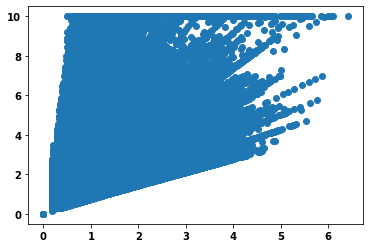

In [178]:
plt.scatter(temp.X.ravel(), orig.ravel()) #### NOT the same....

In [169]:
#### Perhaps best option is to try & reverse normalisation to get raw counts????
def pow_e(values):
    return np.power(values, np.e)

unlogged = np.apply_along_axis(pow_e, 1, orig)
scales = unlogged.sum(axis=1)

unlogged

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  6.1217723,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  5.2132373,
         0.       ],
       [ 0.       ,  0.       ,  3.4544582, ...,  9.857896 , 14.018367 ,
         0.       ],
       ...,
       [ 0.       ,  0.       , 49.125908 , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.7962706,
         0.       ],
       [ 0.       ,  0.       ,  6.5621524, ...,  0.       ,  1.9428195,
         0.       ]], dtype=float32)

## Trying to reproduce using code from the github..

https://github.com/czbiohub/tabula-sapiens/blob/master/Fig1/Train_scVI.ipynb

https://zenodo.org/record/6069683#.YzoOMexBy3I

In [6]:
### Found the raw code here: https://zenodo.org/record/6069683#.YzoOMexBy3I
# Will try how they did it...
# orig = data[0:1000, data.var['highly_variable'].values].to_df().values

# data.layers['log1p'] = data.X ### Cacheing....

In [7]:
# data.X = data.layers['decontXcounts'].copy()
# sc.pp.normalize_total(data, target_sum=1e4)
# sc.pp.log1p(data)
# sc.pp.scale(data, max_value=10, zero_center=False)

In [14]:
data.layers['decontXcounts'][0:1000, data.var['highly_variable'].values].toarray()

array([[0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 6., 0.],
       ...,
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]], dtype=float32)

In [8]:
data.X.min()

0.0

In [9]:
orig_test = data[0:1000, data.var['highly_variable'].values].to_df().values

In [10]:
print(orig)
print(orig_test)

[[0.        0.        0.        ... 0.        1.9474932 0.       ]
 [0.        0.        0.        ... 0.        1.8357313 0.       ]
 [0.        0.        1.5778253 ... 2.32056   2.6414745 0.       ]
 ...
 [0.        0.        4.1898494 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.919607  0.       ]
 [0.        0.        1.9979037 ... 0.        1.2767574 0.       ]]
[[0.        0.        0.        ... 0.        1.9634337 0.       ]
 [0.        0.        0.        ... 0.        1.850757  0.       ]
 [0.        0.        1.5947624 ... 2.3077052 2.6630952 0.       ]
 ...
 [0.        0.        4.234825  ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.9271341 0.       ]
 [0.        0.        2.01935   ... 0.        1.2872077 0.       ]]


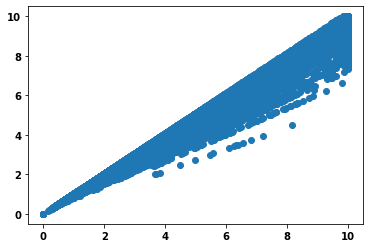

In [11]:
plt.scatter(orig_test.ravel(), orig.ravel()) #### Almost the same... but close enough. will ask on github anyhow...

## Understanding metadata!

In [137]:
data.obs.dtypes

organ_tissue              category
method                    category
donor                     category
anatomical_information    category
n_counts_UMIs              float32
n_genes                      int64
cell_ontology_class       category
free_annotation           category
manually_annotated            bool
compartment               category
gender                    category
dtype: object

In [8]:
data.obs['manually_annotated_str'] = data.obs['manually_annotated'].values.astype(str)
data.obs['manually_annotated_str'] = data.obs['manually_annotated_str'].astype('category')

In [9]:
data.obs.iloc[0:3, :]

organ_tissue method donor  \
cell_id                                                            
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1        Liver    10X  TSP6   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1        Liver    10X  TSP6   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1        Liver    10X  TSP6   

                                       anatomical_information  n_counts_UMIs  \
cell_id                                                                        
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                    nan         7633.0   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                    nan         2858.0   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1                    nan         7787.0   

                                        n_genes  \
cell_id                                           
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1     2259   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1     1152   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1     2983   

                                                         cell_ontology_class  \
cell_id                                                                        
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                            macrophage   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                              monocyte   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1  endothelial cell of hepatic sinusoid   

                                            free_annotation  \
cell_id                                                       
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1  Monocyte/Macrophage   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1             Monocyte   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1          Endothelial   

                                        manually_annotated  compartment  \
cell_id                                                                   
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                True       immune   
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                True       immune   
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1                True  endothelial   

                                       gender manually_annotated_str  
cell_id                                                               
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1   male                   True  
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1   male                   True  
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1   male                   True

Oh my! There is a boolean column indicating manual annotations!!! Fantastic. This is GREAT; and means I can definitely check whether these manual annotations are GOOD or not.

Let's see how many there are!

In [10]:
data.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_scvi, X_scvi_umap, X_umap)

In [14]:
?sc.pl.embedding

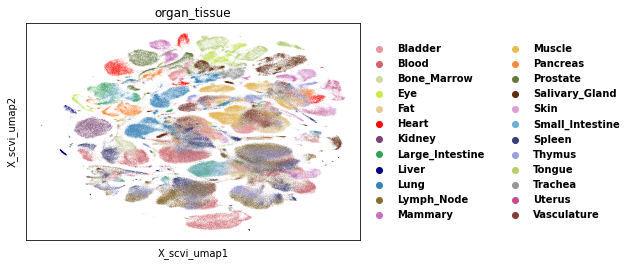

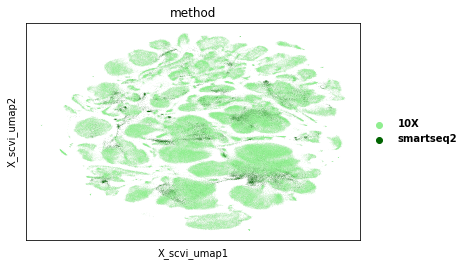

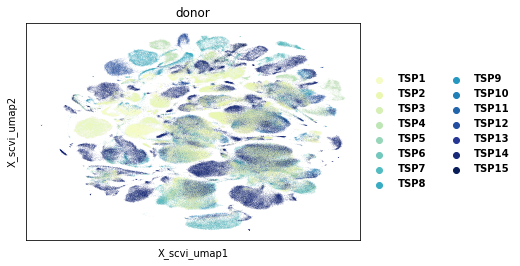

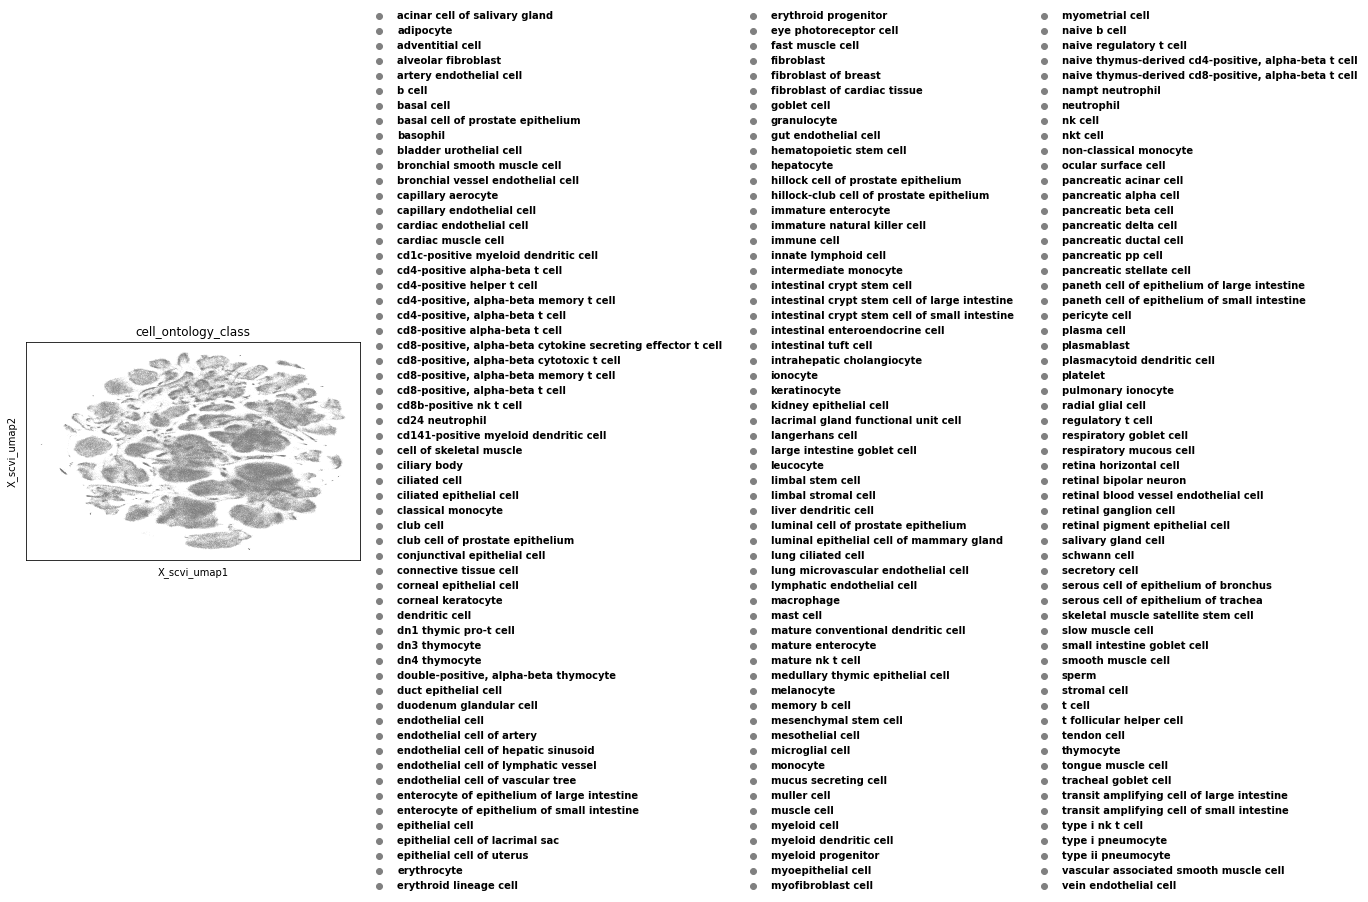

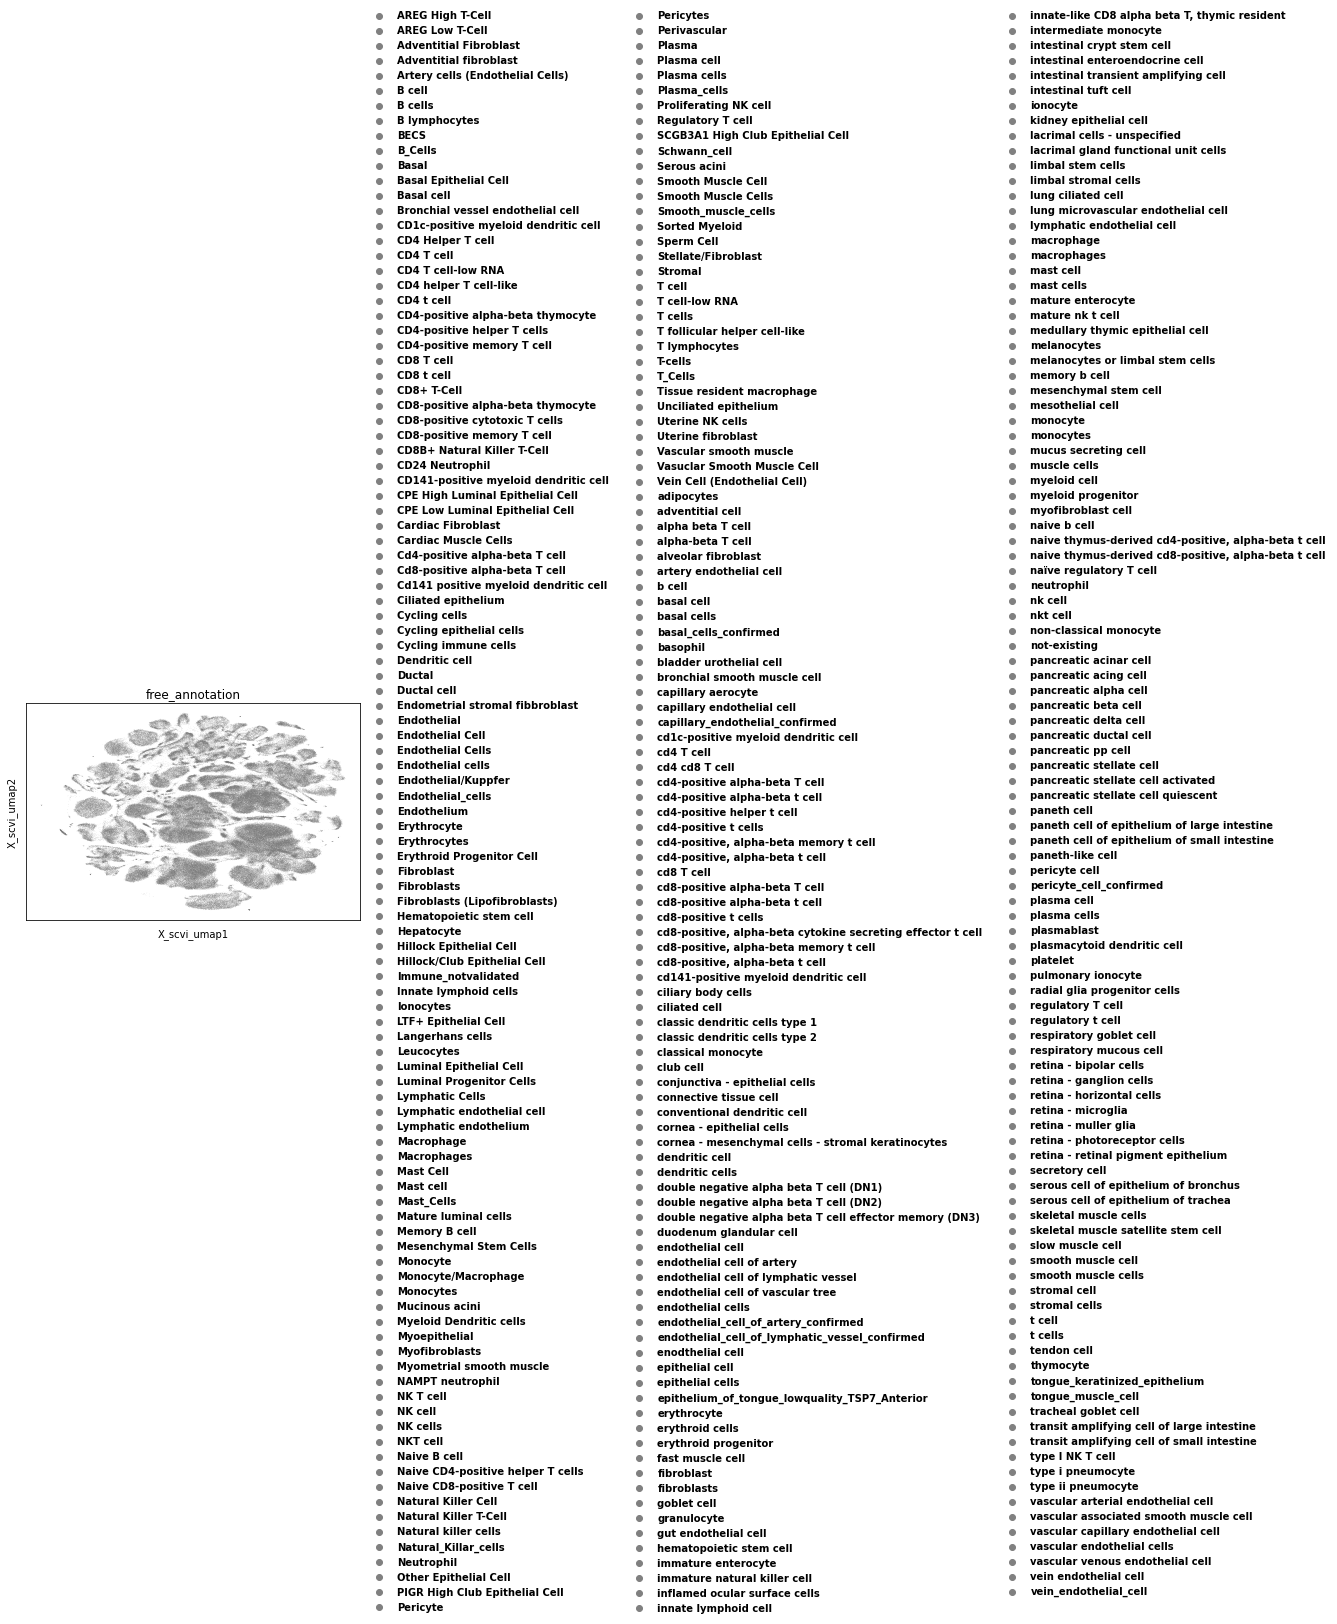

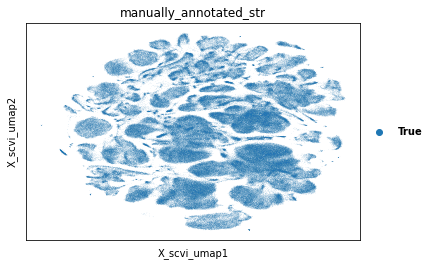

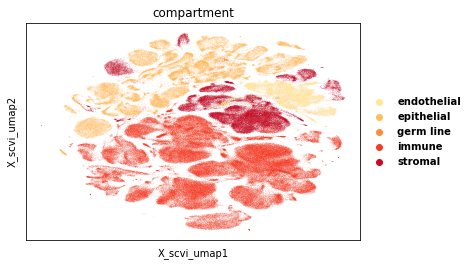

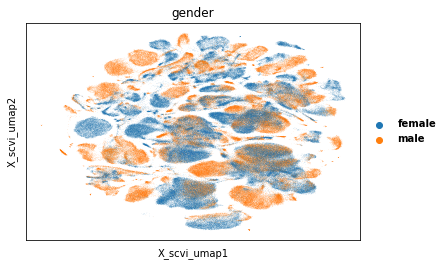

In [11]:
cols = ['organ_tissue', 'method', 'donor', 'cell_ontology_class', 
        'free_annotation', 'manually_annotated_str', 'compartment', 'gender']
for col in cols:
    sc.pl.embedding(data, 'X_scvi_umap', color=col)

In [14]:
out_plots

'plots/coexpr_score/sapiens/'

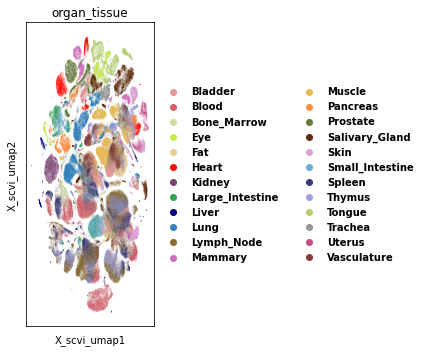

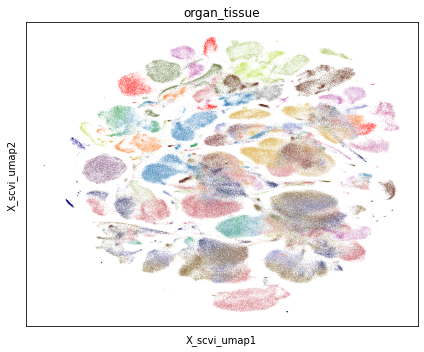

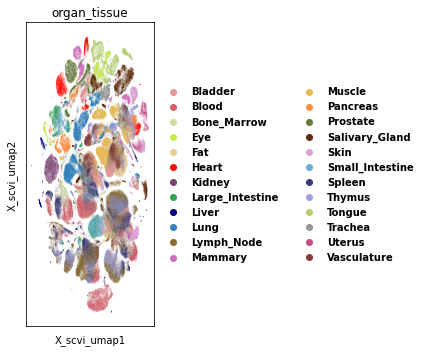

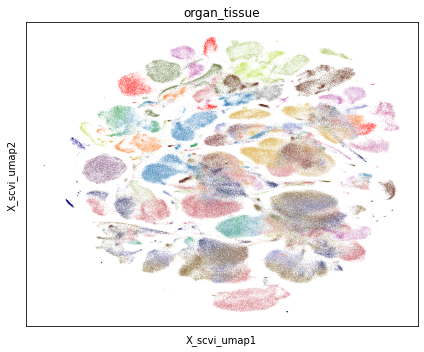

In [78]:
fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.embedding(data, 'X_scvi_umap', color='organ_tissue', ax=ax, show=False)
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.embedding(data, 'X_scvi_umap', color='organ_tissue', ax=ax, legend_loc=None, show=False)
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.embedding(data, 'X_scvi_umap', color='organ_tissue', ax=ax, show=False)
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.embedding(data, 'X_scvi_umap', color='organ_tissue', ax=ax, legend_loc=None, show=False)
plt.show()

In [12]:
data.var.keys()

Index(['gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm', 'mean', 'std'],
      dtype='object')

In [13]:
print(sum(data.var['highly_variable'].values))

2435


# Cytocipher enrichment on manual annotations..

In [53]:
data.obs.keys()

Index(['organ_tissue', 'method', 'donor', 'anatomical_information',
       'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation',
       'manually_annotated', 'compartment', 'gender', 'organ_tissue_merged'],
      dtype='object')

In [ ]:
cell_type = 'cell_ontology_class'
cc.tl.get_markers(data, cell_type, var_groups='highly_variable')
data.uns[f'{cell_type}_markers']

In [59]:
cc.tl.coexpr_enrich(data, cell_type, n_cpus=15)

Added data.obsm['cell_ontology_class_enrich_scores']


/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)


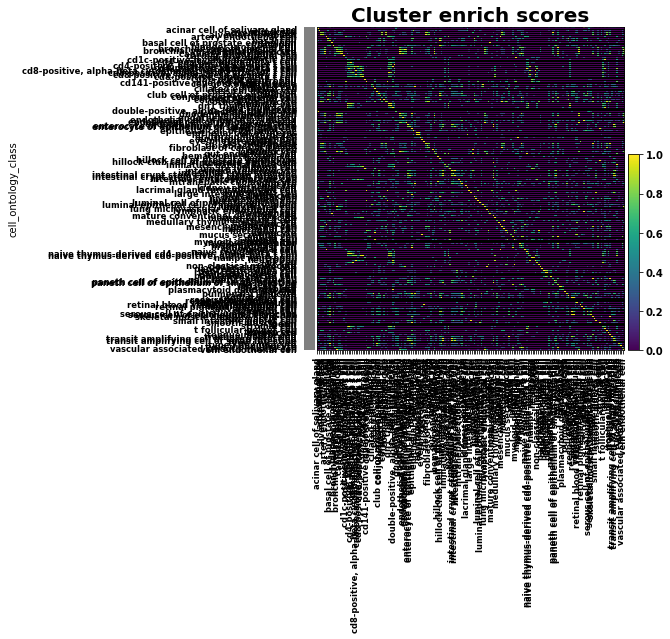

In [62]:
cc.pl.enrich_heatmap(data, cell_type, figsize=(6,6), n_clust_cells=20)

In [ ]:
cc.tl.code_enrich(data, cell_type, n_cpus=15, squash_exception=True)

/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)


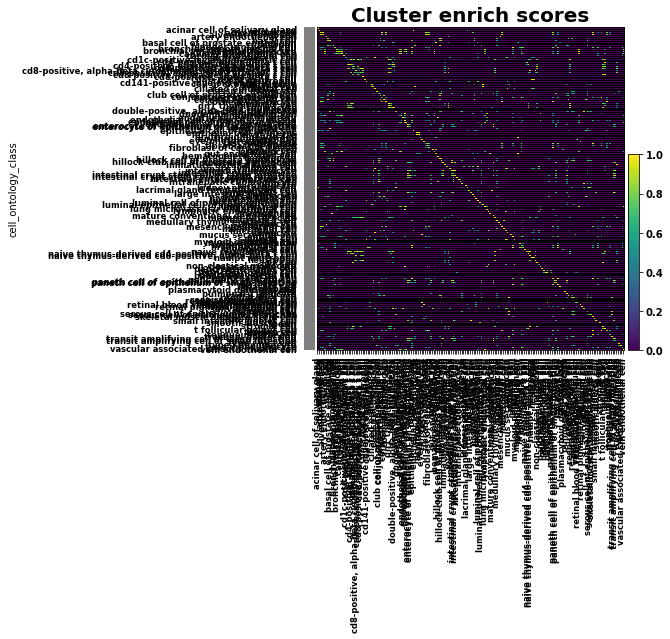

In [65]:
cc.pl.enrich_heatmap(data, cell_type, figsize=(6,6), n_clust_cells=20)

In [71]:
?cc.pl.enrich_heatmap

In [70]:
?sc.pl.heatmap

In [73]:
import cytocipher.plotting.cluster_diagnostics as cd
imp.reload(cd)
imp.reload(cc.pl)

<module 'cytocipher.pl' from '/home/s4392586/myPython/Cytocipher/cytocipher/pl.py'>

/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:111: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)
/home/s4392586/myPython/BeautifulCells/beautifulcells/visualisation/helpers.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


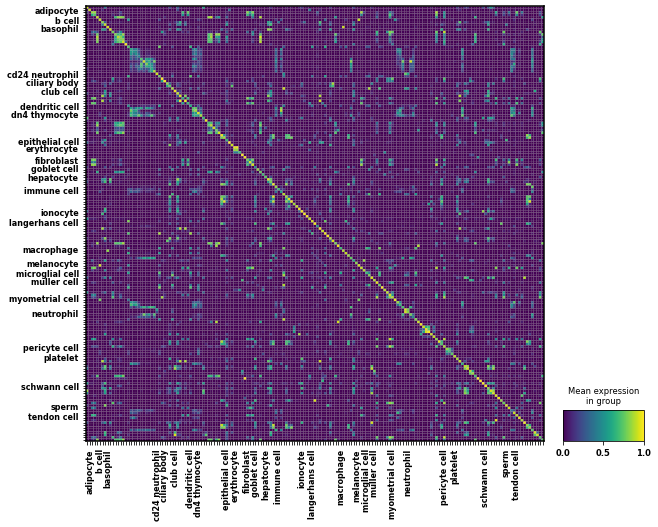

In [121]:
ax = cc.pl.enrich_heatmap(data, cell_type, figsize=(10,8), n_clust_cells=20, per_cell=False, show=False)
labels = ax['mainplot_ax'].get_xticklabels()
new_labels = []
for i, label in enumerate(labels):
    props = label.properties()
    if len(props['text'])<16 and np.all([new_labels[i-j-1]=='' for j in range(2)]): #i%2==0:
        new_labels.append( label )
    else:
        new_labels.append( '' )

fontdict={'fontsize': 8}
ax['mainplot_ax'].set_xticklabels(new_labels, fontdict=fontdict)
ax['mainplot_ax'].set_yticklabels(new_labels, fontdict=fontdict)

plt.show()

In [122]:
len(labels)

177

## Let's try an over-clustering case, whereby within each cell type we randomly put into groups, and see if Cytocipher can distinguish true from false groups and create a good ROC AUC.

In [95]:
?np.random.choice

In [109]:
truth_col = 'cell_ontology_class'
truth_labels = data.obs[truth_col].values.astype(str)
truth_set = np.unique( truth_labels )

n_subclusters = 3
overcluster_labels = np.array([' '*max([len(truth+'_number') for truth in truth_set])]*len(truth_labels))
n_cells = []
n_rand_cells = []
for i, truth in enumerate(truth_set):
    truth_indices = np.where( truth_labels==truth )[0]
    n_cells.append( len(truth_indices) )
    if len(truth_indices) > 20:
        n_rands = [len(truth_indices)//n_subclusters for i_ in range(n_subclusters)]
        n_rands[0] += len(truth_indices)%n_subclusters
    else:
        n_rands = [len(truth_indices)]
    
    sampled_indices = []
    for sampj in range(len(n_rands)):
        indices = np.random.choice([index for index in truth_indices if index not in sampled_indices], 
                                   n_rands[sampj], replace=False)
        sampled_indices.extend( indices )
        
        overcluster_labels[indices] = f'{truth}_{sampj}'
        n_rand_cells.append(len(indices))
        
    #print(np.all(np.unique(sampled_indices)==np.unique(truth_indices)))

In [116]:
#### Now setting the overclusters...
data.obs[f'overclusters'] = overcluster_labels
data.obs[f'overclusters'] = data.obs[f'overclusters'].astype('category')

## Now running Cytocipher on the over-clusters to generate ROC AUC curve...

In [120]:
?cc.tl.merge_clusters

In [121]:
import cytocipher.score_and_merge.cluster_merge as cm
imp.reload(cm)
imp.reload(cc.tl)

<module 'cytocipher.tl' from '/home/s4392586/myPython/Cytocipher/cytocipher/tl.py'>

In [20]:
data.shape

(483152, 58870)

In [122]:
#### Now let's call significant difference...
cc.tl.merge_clusters(data, 'overclusters', var_groups='highly_variable', n_cpus=15, max_iter=0,
                     enrich_method='code', 
                      k=15, squash_exception=True,
                     )

Initial merge.


/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

Full overlap of + and - gene sets detected for acinar cell of salivary gland_0 and acinar cell of salivary gland_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for acinar cell of salivary gland_0 and acinar cell of salivary gland_2; suggested to increase number of marker genes for scoring.


/home/s4392586/myPython/Cytocipher/cytocipher/score_and_merge/cluster_score.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all( np.unique(cluster_genes_dict[clusterj])==\


Full overlap of + and - gene sets detected for acinar cell of salivary gland_1 and acinar cell of salivary gland_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for acinar cell of salivary gland_1 and acinar cell of salivary gland_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for acinar cell of salivary gland_2 and acinar cell of salivary gland_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for acinar cell of salivary gland_2 and acinar cell of salivary gland_1; suggested to increase number of marker genes for scoring.


/home/s4392586/myPython/Cytocipher/cytocipher/score_and_merge/cluster_score.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all( np.unique(cluster_genes_dict[clusterj])==\


Full overlap of + and - gene sets detected for alveolar fibroblast_0 and alveolar fibroblast_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for alveolar fibroblast_1 and alveolar fibroblast_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for b cell_0 and b cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for b cell_0 and b cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for b cell_0 and memory b cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for b cell_0 and memory b cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for b cell_0 and memory b cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene se

Full overlap of + and - gene sets detected for cd4-positive helper t cell_0 and cd4-positive helper t cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for cd4-positive helper t cell_0 and cd4-positive helper t cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for cd4-positive helper t cell_1 and cd4-positive helper t cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for cd4-positive helper t cell_1 and cd4-positive helper t cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for cd4-positive helper t cell_2 and cd4-positive helper t cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for cd4-positive helper t cell_2 and cd4-positive helper t cell_1; suggested to increase number of marker genes for s

Full overlap of + and - gene sets detected for corneal epithelial cell_0 and corneal epithelial cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for corneal epithelial cell_0 and corneal epithelial cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for corneal epithelial cell_1 and corneal epithelial cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for corneal epithelial cell_1 and corneal epithelial cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for corneal epithelial cell_2 and corneal epithelial cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for corneal epithelial cell_2 and corneal epithelial cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene

Full overlap of + and - gene sets detected for fibroblast of breast_0 and fibroblast of breast_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for fibroblast of breast_0 and fibroblast of breast_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for fibroblast of breast_1 and fibroblast of breast_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for fibroblast of breast_1 and fibroblast of breast_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for fibroblast of breast_2 and fibroblast of breast_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for fibroblast of breast_2 and fibroblast of breast_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for fibroblast of car

Full overlap of + and - gene sets detected for lung microvascular endothelial cell_0 and lung microvascular endothelial cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for lung microvascular endothelial cell_0 and lung microvascular endothelial cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for lung microvascular endothelial cell_0 and vein endothelial cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for lung microvascular endothelial cell_0 and vein endothelial cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for lung microvascular endothelial cell_0 and vein endothelial cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for lung microvascular endothelial cell_1 and lung microvascular endo

Full overlap of + and - gene sets detected for monocyte_1 and monocyte_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for monocyte_2 and monocyte_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for myeloid cell_0 and myeloid cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for myeloid cell_2 and myeloid cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for myofibroblast cell_0 and myofibroblast cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for myofibroblast cell_0 and myofibroblast cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for myofibroblast cell_1 and myofibroblast cell_0; suggested to increase number of marker genes for scoring.


Full overlap of + and - gene sets detected for plasmacytoid dendritic cell_1 and plasmacytoid dendritic cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for plasmacytoid dendritic cell_2 and plasmacytoid dendritic cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for platelet_0 and platelet_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for platelet_2 and platelet_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for regulatory t cell_0 and regulatory t cell_2; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for regulatory t cell_2 and regulatory t cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for respiratory goblet cell_0 and respiratory goblet 

Full overlap of + and - gene sets detected for type ii pneumocyte_0 and type ii pneumocyte_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for type ii pneumocyte_1 and type ii pneumocyte_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for vascular associated smooth muscle cell_0 and vascular associated smooth muscle cell_1; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for vascular associated smooth muscle cell_1 and vascular associated smooth muscle cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for vascular associated smooth muscle cell_2 and smooth muscle cell_0; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for vascular associated smooth muscle cell_2 and smooth muscle cell_1; suggested to increase numb

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.p

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_grou

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/tools/_rank_genes_g

Added data.obs[f'overclusters_merged']
Exiting due to reaching max_iter 0


In [28]:
data.obs['overclusters'].cat.categories

Index(['acinar cell of salivary gland_0', 'acinar cell of salivary gland_1',
       'acinar cell of salivary gland_2', 'adipocyte_0', 'adipocyte_1',
       'adipocyte_2', 'adventitial cell_0', 'adventitial cell_1',
       'adventitial cell_2', 'alveolar fibroblast_0',
       ...
       'type i pneumocyte_2', 'type ii pneumocyte_0', 'type ii pneumocyte_1',
       'type ii pneumocyte_2', 'vascular associated smooth muscle cell_0',
       'vascular associated smooth muscle cell_1',
       'vascular associated smooth muscle cell_2', 'vein endothelial cell_0',
       'vein endothelial cell_1', 'vein endothelial cell_2'],
      dtype='object', length=503)

In [69]:
#### Trying different settings for the p-value cutoff....
import cytocipher.score_and_merge.cluster_merge as cm

p_cut = .5
cm.merge(data, 'overclusters', p_cut, use_p_adjust=True)
print(len(np.unique(data.obs['overclusters_merged'])))

Added data.uns['overclusters_mutualpairs']
Added data.obs['overclusters_merged']
214


In [70]:
##### Let's do this!!!
colors = vhs.getColors(data.obs[cell_type])
data.uns[f'{cell_type}_colors'] = [colors[ct] for ct in data.obs[cell_type].cat.categories]
data.uns[f'overclusters_colors'] = [colors['_'.join(clust.split('_')[0:-1])] for clust in data.obs['overclusters'].cat.categories]

colors2 = vhs.getColors(data.obs['overclusters_merged'])
data.uns[f'overclusters_merged_colors'] = [colors2[clust] for clust in data.obs['overclusters_merged'].cat.categories]

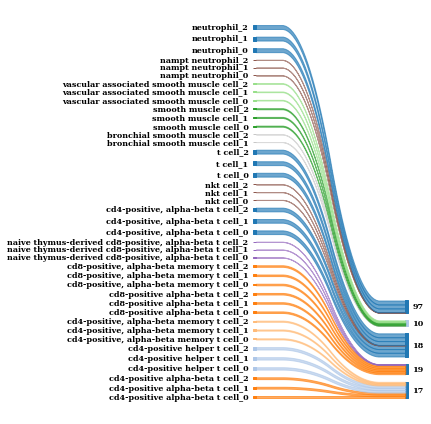

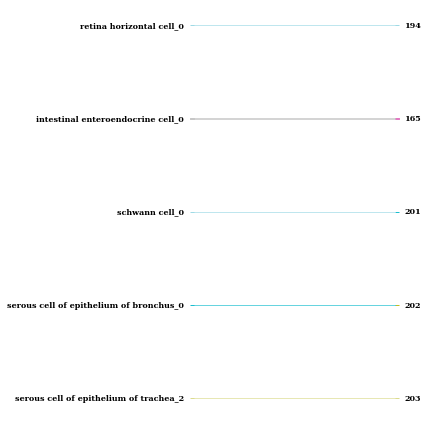

In [77]:
#### What clusters get merged?
import cytocipher.plotting.cluster_diagnostics as cd
imp.reload(cd)
imp.reload(cc.pl)

cc.pl.merge_sankey(data, 'overclusters', show_range=(0, 5))
plt.rc('font', family='sans-serif') # Switch back to default font
plt.show()

cc.pl.merge_sankey(data, 'overclusters', show_range=(214-5, 214))
plt.rc('font', family='sans-serif') # Switch back to default font
plt.show()

In [ ]:
### Saving results..
data.write_h5ad(data_dir+'TabulaSapiens_Cytociphered.h5ad', compression='gzip')